In [1]:
import dice_ml

import pandas as pd
import numpy as np 

from sklearn.datasets import make_moons

import matplotlib.pyplot as plt

/home/amine/.local/lib/python3.9/site-packages/dice_ml/utils/exception.py:12: UserWarning: UserConfigValidationException will be deprecated from dice_ml.utils. Please import UserConfigValidationException from raiutils.exceptions.
  warnings.warn("UserConfigValidationException will be deprecated from dice_ml.utils. "


In [2]:
def generate_halfmoons(n_samples,noise,verbose=True):
    X , y = make_moons(n_samples,noise=noise)

    if verbose  : plt.scatter(X[:,0],X[:,1],c=y)
    
    return X , y



def plot_decision_boundary(X, y, model,sample,contrf,title="Counterfactual"):
   
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

    Z = np.round(model.predict(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    
    if sample is not None:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
        plt.scatter(sample[0], sample[1], c='red', marker='o', s=50, label='Sample')
        for con in contrf[:-1]:
            plt.scatter(con[0], con[1], c='green', marker='X', s=50)
        plt.scatter(contrf[-1][0], contrf[-1][1], c='green', marker='X', s=50,label=title)
    else:
        plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)
    plt.title("Grawing Sphere "+title)
    plt.xlabel("dim 1")
    plt.ylabel("dim 2")
    plt.legend()
    plt.show()

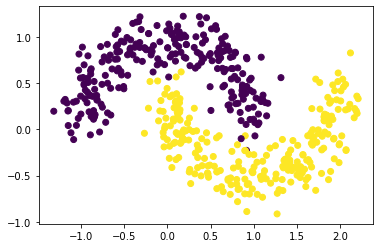

In [3]:
n_samples = 500
noise = 0.15
X , y = generate_halfmoons(n_samples,noise,verbose=True)

In [4]:
df = pd.DataFrame(X,columns=["x1","x2"])
# df.insert(2, "class",y, True)
df["class"] = y 
df

,x1,x2,class
0,1.272514,-0.691282,1
1,0.983181,-0.644358,1
2,-0.784392,-0.027134,0
3,-0.165403,0.622965,0
4,0.915660,-0.226386,0
...,...,...,...
495,1.812521,0.136608,1
496,0.778042,0.575674,0
497,-0.949403,0.426777,0
498,0.052410,-0.412320,1


In [5]:
data = dice_ml.Data(dataframe = df,continuous_features = ["x1","x2"],outcome_name="class")

## Classifiers

In [6]:
import tensorflow as tf
from tensorflow import keras

# Charger vos données d'entraînement et de test (X_train, y_train, X_test, y_test)

# Définir le modèle
trained_classifier = keras.Sequential([
    keras.layers.Input(shape=(2,)),  # Deux caractéristiques en entrée
    keras.layers.Dense(5, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')# Deux classes de sortie avec softmax
])

# Compiler le modèle
trained_classifier.compile(optimizer='adam',
              loss='mse',  # Fonction de perte pour classification
              metrics=['accuracy'])  # Métrique à surveiller pendant l'entraînement

# Entraîner le modèle
trained_classifier.fit(X, y, epochs=100, batch_size=32)

2023-10-02 11:26:12.794036: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-02 11:26:16.996380: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-10-02 11:26:16.996458: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-10-02 11:26:24.870936: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Epoch 1/100
16/16 [==============================] - 1s 5ms/step - loss: 0.2394 - accuracy: 0.5620
Epoch 2/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2332 - accuracy: 0.6020
Epoch 3/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2275 - accuracy: 0.7500
Epoch 4/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2222 - accuracy: 0.7860
Epoch 5/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.8000
Epoch 6/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2123 - accuracy: 0.8060
Epoch 7/100
16/16 [==============================] - 0s 1ms/step - loss: 0.2074 - accuracy: 0.8140
Epoch 8/100
16/16 [==============================] - 0s 2ms/step - loss: 0.2029 - accuracy: 0.8200
Epoch 9/100
16/16 [==============================] - 0s 2ms/step - loss: 0.1983 - accuracy: 0.8220
Epoch 10/100
16/16 [==============================] - 0s 1ms/step - loss: 0.1938 - accuracy: 0.8260
Epoch 11/

16/16 [==============================] - 0s 1ms/step - loss: 0.0803 - accuracy: 0.8820
Epoch 84/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0801 - accuracy: 0.8840
Epoch 85/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0799 - accuracy: 0.8840
Epoch 86/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0797 - accuracy: 0.8860
Epoch 87/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0795 - accuracy: 0.8860
Epoch 88/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0793 - accuracy: 0.8860
Epoch 89/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0792 - accuracy: 0.8880
Epoch 90/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0790 - accuracy: 0.8880
Epoch 91/100
16/16 [==============================] - 0s 1ms/step - loss: 0.0788 - accuracy: 0.8880
Epoch 92/100
16/16 [==============================] - 0s 2ms/step - loss: 0.0787 - accuracy: 0.8880
Epoch 93/100


In [7]:
model = dice_ml.Model(model=trained_classifier, backend="TF1")

In [8]:
explainer = dice_ml.Dice(data, model)

In [9]:
query_inst = pd.DataFrame(df.iloc[0:1,:2],columns=["x1","x2"])

counterfactuals = explainer.generate_counterfactuals(
    query_inst,
    5,
    desired_class="opposite",
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary="all",
    permitted_range=None,
    posthoc_sparsity_param=0.1)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.33s/it]


In [10]:
counterfactuals.visualize_as_dataframe()

Query instance (original outcome : 1)


,x1,x2,class
0,1.272514,-0.691282,1



Diverse Counterfactual set (new outcome: 0.0)


,x1,x2,class
0,-0.717126,0.292937,0
1,0.235893,0.217815,0
2,-0.837468,0.997643,0
3,1.117075,1.129175,0
4,-0.238643,0.666745,0


In [11]:
enemies = counterfactuals.cf_examples_list[0].final_cfs_df

7172/7172 [==============================] - 6s 795us/step


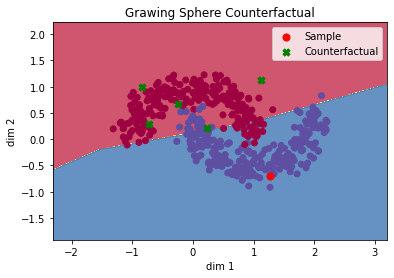

In [12]:
plot_decision_boundary(X, y,trained_classifier,X[0],np.array(enemies))

In [13]:
query_inst = pd.DataFrame(df.iloc[25:26,:2],columns=["x1","x2"])

counterfactuals = explainer.generate_counterfactuals(
    query_inst,
    5,
    desired_class="opposite",
    proximity_weight=0.5,
    diversity_weight=1.0,
    features_to_vary="all",
    permitted_range=None,
    posthoc_sparsity_param=0.1)

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.24s/it]


In [14]:
enemies = counterfactuals.cf_examples_list[0].final_cfs_df

7172/7172 [==============================] - 6s 820us/step


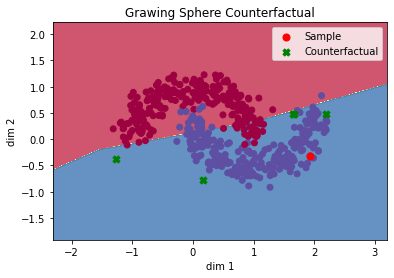

In [15]:
plot_decision_boundary(X, y,trained_classifier,X[96],np.array(enemies))